In [1]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count, Sum
sys.path.append('/home/galm/software/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from django.forms.models import model_to_dict

from scoping.models import *
from tmv_app.models import *
from scipy import stats
import ipy_table as tbl

run_id = 96
qid = 1053

In [2]:
docs = Doc.objects.filter(query=qid)

In [6]:
calc_sizes = False
if calc_sizes:
    topic_sizes = {}
    docs = Doc.objects.filter(query=qid,doctopic__isnull=False).distinct('UT')
    for doc in docs.iterator():
        t = doc.doctopic_set.filter(run_id=96).order_by('-score').first()
        try:
            topic_sizes[t.topic.title] +=1
        except:
            topic_sizes[t.topic.title] = 1

    print(topic_sizes)

    for key in topic_sizes:
        print(key)
        value = topic_sizes[key]
        topic = Topic.objects.get(run_id=run_id,title=key)
        topic.size = value
        print(topic.size)
        topic.save()

{'{transport, public, servic}': 330, '{vehicl, charg, electr}': 241, '{urban, land, citi}': 309, '{treatment, water, wastewat}': 245, '{travel, mode, choic}': 317, '{polici, develop, plan}': 853, '{air, pollut, exposur}': 222, '{bicycl, cycl, cyclist}': 146, '{recycl, household, collect}': 193, '{build, energi, perform}': 349, '{green, roof, infrastructur}': 158, '{transit, bus, servic}': 393, '{emiss, carbon, ghg}': 217, '{heat, thermal, temperatur}': 381, '{wast, manag, solid}': 525, '{toll, lane, link}': 186, '{model, network, optim}': 482, '{park, space, price}': 225, '{hous, passiv, construct}': 143, '{energi, consumpt, effici}': 467, '{price, congest, road}': 316, '{activ, school, walk}': 379}


In [150]:
topic_sizes = list(Topic.objects.filter(run_id=run_id).values('title','size'))
topics = pd.DataFrame.from_dict(list(topic_sizes)).rename(columns={'title':'topic','size':'topic_size'})
topics.head()

,topic_size,topic
0,853,"{polici, develop, plan}"
1,467,"{energi, consumpt, effici}"
2,525,"{wast, manag, solid}"
3,316,"{price, congest, road}"
4,225,"{park, space, price}"


In [14]:
tvalues = []
dns = 0
for d in docs:
    
    ns = [x for x in re.findall("[^0-9]+([2-3{1}][0-9]{3})[^0-9]+",d.content) if int(x) > 2017 and int(x) < 2101]
    if len(ns) > 0:
        dns+=1
        t = d.doctopic_set.filter(run_id=96).order_by('-score').first()
        for n in ns:
            v = {
                "doc" : d.UT,
                "topic" : t.topic.title,
                "topic_size" : t.topic.size,
                "number" : n,
                "abstract": d.content
            }
            tvalues.append(v)
            
print(dns)

186


In [151]:
df = pd.DataFrame.from_dict(list(tvalues))
df['number'] = pd.to_numeric(df['number'])
df.head()
len(df)

234

In [252]:
pdf = df[['topic','number']]
g = pdf.groupby('topic').agg('median').sort_values('number')
g['topic'] = g.index
g = g.reset_index(drop=True)
g['order'] = g.index

pdf = pd.merge(pdf,g[['topic','order']])
pdf['topic'] = pdf.apply(lambda x: "{:02d} {}".format(x['order'], x['topic']) , axis=1)

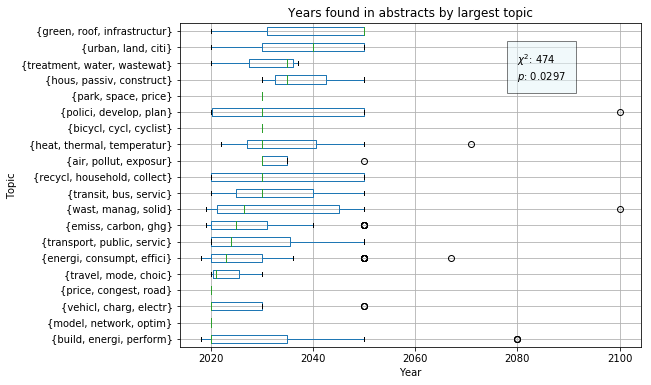

In [270]:
import matplotlib.pyplot as plt
crosstab = pd.crosstab(df['topic'],df['number'])
chi2, p, dof, expected = stats.chi2_contingency(crosstab.values)

tbl.make_table(results)
plt.rcParams["figure.figsize"] = [8,6]
pdf.boxplot(column='number', by='topic', vert=False)
plt.savefig('../plots/topic_years.png',bbox_inches='tight')  

plt.text(
    2080,17,'$\chi^2$: {0:.3g}\n$p$: {1:.3g}'.format(chi2,p),
    bbox={'facecolor':'#e5f5f9', 'alpha':0.5, 'pad':10}
)

plt.title('Years found in abstracts by largest topic')
plt.suptitle('')

#fig, ax = plt.subplots()
plt.yticks(g.index+1,g.topic)
plt.xlabel('Year')
plt.ylabel('Topic')

plt.show()


In [258]:
df.to_csv("../data/years.csv")

In [273]:
g = df[['topic','number']].groupby(['topic'], as_index=False)
g = g.agg(['median','mean',np.std, 'count'], as_index=False).rename(columns={'std': 'std dev'}).reset_index()
g.columns = g.columns.get_level_values(0) + "_" + g.columns.get_level_values(1)
g = g.rename(columns={'topic_':'topic'}).sort_values('number_median')

topic_summary = pd.merge(g,topics,how='right')
print(topic_summary)
topic_summary.to_csv("../data/year_summaries.csv")

                           topic  number_median  number_mean  number_std dev  \
0       {build, energi, perform}         2020.0  2032.476190       22.037738   
1        {model, network, optim}         2020.0  2020.000000             NaN   
2        {vehicl, charg, electr}         2020.0  2027.777778       11.143743   
3         {price, congest, road}         2020.0  2020.000000             NaN   
4          {travel, mode, choic}         2021.0  2023.666667        5.507571   
5     {energi, consumpt, effici}         2023.0  2028.435484       11.228799   
6    {transport, public, servic}         2024.0  2029.181818       12.064976   
7           {emiss, carbon, ghg}         2025.0  2029.513514       10.856697   
8           {wast, manag, solid}         2026.5  2036.700000       25.002444   
9         {transit, bus, servic}         2030.0  2033.333333       15.275252   
10  {recycl, household, collect}         2030.0  2034.000000       15.165751   
11        {air, pollut, exposur}        